# Local Development and Validation

This notebook will cover the core parts of the machine learning workflow, running locally within the Google Cloud Datalab environment. Local development and validation, along with using a sample of the full dataset, is recommended as a starting point. This allows for a shorter development-validation iteration cycle.

## Workspace Setup

The first step is to setup the workspace that we will use within this notebook - the python libraries, and the local directory containing the data inputs and outputs produced over the course of the steps.

In [19]:
import google.datalab.ml as ml
import json
import math
import matplotlib.pyplot as plot
import mltoolbox.regression.dnn as regression
import numpy as np
import pandas as pd
import os
import seaborn as sns
import sklearn.metrics as metrics

The local development workspace will be in `/content/datalab/workspace/census` by default.

Note that the `/content/datalab` directory is physically located within the data disk mounted into the Datalab instance, but outside of the git repository containing notebooks, which makes it suitable for storing data files and generated files that are useful to keep around while you are working on a project, but do not belong in the source repository.

In [20]:
workspace_path = '/content/datalab/workspace/census'

In [21]:
!mkdir -p {workspace_path}

NOTE: If you have previously run this notebook, and want to start from scratch, then run the next cell to delete and create the workspace directory.

In [22]:
!rm -rf {workspace_path} && mkdir {workspace_path}

To get started, we will copy the data into this workspace. Generally, in your own work, you will need to create a representative sample dataset to use for local development, while leaving the full dataset to use when running on the service. For purposes of the sample, which uses a relatively small dataset, we'll copy it down in entirety.

In [23]:
!gsutil -q cp gs://cloud-datalab-samples/census/ss14psd.csv {workspace_path}/data/census.csv

In [24]:
!ls -l {workspace_path}/data

total 8000
-rw-r--r-- 1 root root 8189323 Dec 31 20:33 census.csv


## Data Exploration
Its a good idea to load data and inspect it to build an understanding of the structure, as well as preparation steps that will be needed.

In [25]:
df_data = pd.read_csv(os.path.join(workspace_path, 'data/census.csv'), dtype=str)
print '%d rows' % len(df_data)
df_data.head()

8626 rows


,RT,SERIALNO,SPORDER,PUMA,ST,ADJINC,PWGTP,AGEP,CIT,CITWP,...,pwgtp71,pwgtp72,pwgtp73,pwgtp74,pwgtp75,pwgtp76,pwgtp77,pwgtp78,pwgtp79,pwgtp80
0,P,25,01,00400,46,1008425,00038,85,1,,...,00011,00010,00008,00032,00040,00038,00033,00040,00068,00090
1,P,467,01,00600,46,1008425,00120,62,1,,...,00119,00039,00034,00119,00125,00104,00119,00102,00184,00038
2,P,490,01,00500,46,1008425,00172,64,1,,...,00049,00045,00148,00163,00313,00174,00153,00165,00158,00126
3,P,490,02,00500,46,1008425,00113,67,1,,...,00037,00032,00107,00125,00249,00107,00105,00094,00091,00079
4,P,676,01,00300,46,1008425,00023,89,1,,...,00022,00006,00035,00030,00028,00027,00020,00042,00019,00011


The census data contains a large number of columns. Only a few are needed.

### Data Cleaning and Transformations

The raw census data requires a number of transformations before it is usable for machine learning:

1. Apply understanding of the domain and the problem to determine which data to include or join, as well as which data to filter out if it is adding noise. In the case of census, we'll pick just a few of the many columns present in the dataset.
2. Handle missing values, or variations in formatting.
3. Apply other transformations in support of the problem.

In [26]:
# This code is packaged as a function that can be reused if you need to apply to future
# datasets, esp. to prediction data, to ensure consistent transformations are applied.

def transform_data(df):
  interesting_columns = ['WAGP','SERIALNO','AGEP','COW','ESP','ESR','FOD1P','HINS4','INDP',
                         'JWMNP', 'JWTR', 'MAR', 'POWPUMA', 'PUMA', 'RAC1P', 'SCHL',
                         'SCIENGRLP', 'SEX', 'WKW']
  df = df[interesting_columns]
  
  # Replace whitespace with NaN, and NaNs with empty string
  df = df.replace('\s+', np.nan, regex=True).fillna('')

  # Filter out the rows without an income, i.e. there is no target value to learn from
  df = df[df.WAGP != '']
  
  # Convert the wage value into units of 1000. So someone making an income from wages
  # of $23200 will have it encoded as 23.2
  df['WAGP'] = df.WAGP.astype(np.int64) / 1000.0

  # Filter out rows with income values we don't care about, i.e. outliers
  # Filter out rows with less than 10K and more than 150K
  df = df[(df.WAGP >= 10.0) & (df.WAGP < 150.0)]

  return df

In [27]:
df_data = transform_data(df_data)
print '%d rows' % len(df_data)
df_data.head()

3390 rows


,WAGP,SERIALNO,AGEP,COW,ESP,ESR,FOD1P,HINS4,INDP,JWMNP,JWTR,MAR,POWPUMA,PUMA,RAC1P,SCHL,SCIENGRLP,SEX,WKW
1,70.0,467,62,1,,1,2102,2,6990,015,01,3,00590,00600,1,21,2,1,1
2,19.0,490,64,2,,1,,2,8090,015,01,1,00590,00500,1,18,,2,1
6,70.0,1225,32,5,,4,5301,2,9680,015,01,1,00100,00100,1,21,2,1,1
7,18.0,1225,30,1,,1,,2,8680,020,01,1,00100,00100,1,16,,2,1
11,45.0,1438,55,1,,1,,2,6170,030,01,1,00100,00100,1,16,,1,1


### Creating DataSets

Once the data is ready, the next step is to split data into training and evaluation datasets. In this sample, rows are split randomly in an 80/20 manner. Additionally, the schema is also saved for later use.

In [28]:
def create_schema(df):
  fields = []
  for name, dtype in zip(df.columns, df.dtypes):
    if dtype in (np.str, np.object):
      # Categorical columns should have type 'STRING'
      fields.append({'name': name, 'type': 'STRING'})
    elif dtype in (np.int32, np.int64, np.float32, np.float64):
      # Numerical columns have type 'FLOAT'
      fields.append({'name': name, 'type': 'FLOAT'})
    else:
      raise ValueError('Unsupported column type "%s" in column "%s"' % (str(dtype), name))
  return fields

def create_datasets(df):
  # Numbers in the range of [0, 1)
  random_values = np.random.rand(len(df))

  # Split data into %80, 20% partitions
  df_train = df[random_values < 0.8]
  df_eval = df[random_values >= 0.8]

  return df_train, df_eval

In [29]:
df_train, df_eval = create_datasets(df_data)
schema = create_schema(df_data)

training_data_path = os.path.join(workspace_path, 'data/train.csv')
eval_data_path = os.path.join(workspace_path, 'data/eval.csv')
schema_path = os.path.join(workspace_path, 'data/schema.json')

df_train.to_csv(training_data_path, header=False, index=False)
df_eval.to_csv(eval_data_path, header=False, index=False)

with open(schema_path, 'w') as f:
  f.write(json.dumps(schema, indent=2))

In [30]:
!ls -l {workspace_path}/data

total 8204
-rw-r--r-- 1 root root 8189323 Dec 31 20:33 census.csv
-rw-r--r-- 1 root root   36290 Dec 31 20:33 eval.csv
-rw-r--r-- 1 root root     998 Dec 31 20:33 schema.json
-rw-r--r-- 1 root root  167265 Dec 31 20:33 train.csv


We'll create DataSet objects which are reference to one or more files identified by a path (or path pattern) along with associated schema.

In [31]:
train_data = ml.CsvDataSet(file_pattern=training_data_path, schema_file=schema_path)
eval_data = ml.CsvDataSet(file_pattern=eval_data_path, schema_file=schema_path)

### Analyzing Data

When building a model, a number of pieces of information about the training data are required - for example, the list of entries or vocabulary of a categorical/discrete column, or aggregate statistics like min and max for numerical columns. These require a full pass over the training data, and is usually done once, and needs to be repeated once if you change the schema in a future iteration.

In [32]:
analysis_path = os.path.join(workspace_path, 'analysis')

regression.analyze(dataset=train_data, output_dir=analysis_path)

Analyze: completed


The output of analysis is a stats file that contains analysis from the numerical columns, and a vocab file from each categorical column.

In [33]:
!ls {analysis_path}

schema.json	vocab_ESR.csv	 vocab_JWTR.csv     vocab_SCHL.csv
stats.json	vocab_FOD1P.csv  vocab_MAR.csv	    vocab_SCIENGRLP.csv
vocab_AGEP.csv	vocab_HINS4.csv  vocab_POWPUMA.csv  vocab_SERIALNO.csv
vocab_COW.csv	vocab_INDP.csv	 vocab_PUMA.csv     vocab_SEX.csv
vocab_ESP.csv	vocab_JWMNP.csv  vocab_RAC1P.csv    vocab_WKW.csv


## Training

All the data is in place to start training. A model learns to predict the target value (the income, 'WAGP'), based on the different pieces of input data (the various columns or features). The target and inputs are defined as features derived from the input data by applying a set of transforms to the columns.

Additionally there is a special key column - this is any column in the data that can be used to uniquely identify instances. The value of this column is ignored during training, but this value is quite useful when using the resulting model during prediction as discussed later.

In [34]:
features = {
  "WAGP": {"transform": "target"},
  "SERIALNO": {"transform": "key"},
  "AGEP": {"transform": "embedding", "embedding_dim": 2},  # Age
  "COW": {"transform": "one_hot"},                         # Class of worker
  "ESP": {"transform": "embedding", "embedding_dim": 2},   # Employment status of parents
  "ESR": {"transform": "one_hot"},                         # Employment status
  "FOD1P": {"transform": "embedding", "embedding_dim": 3}, # Field of degree
  "HINS4": {"transform": "one_hot"},                       # Medicaid
  "INDP": {"transform": "embedding", "embedding_dim": 5},  # Industry
  "JWMNP": {"transform": "embedding", "embedding_dim": 2}, # Travel time to work
  "JWTR": {"transform": "one_hot"},                        # Transportation
  "MAR": {"transform": "one_hot"},                         # Marital status
  "POWPUMA": {"transform": "one_hot"},                     # Place of work
  "PUMA": {"transform": "one_hot"},                        # Area code
  "RAC1P": {"transform": "one_hot"},                       # Race
  "SCHL": {"transform": "one_hot"},                        # School
  "SCIENGRLP": {"transform": "one_hot"},                   # Science
  "SEX": {"transform": "one_hot"},
  "WKW": {"transform": "one_hot"}                          # Weeks worked
}

In [35]:
training_path = os.path.join(workspace_path, 'training')
regression.train(train_dataset=train_data, eval_dataset=eval_data,
                 output_dir=training_path,
                 analysis_dir=analysis_path,
                 features=features,
                 max_steps=2000,
                 layer_sizes=[5, 5, 5])

INFO:tensorflow:loss = 2271.14, step = 1
INFO:tensorflow:Saving dict for global step 1: global_step = 1, loss = 1973.18
INFO:tensorflow:global_step/sec: 46.0365
INFO:tensorflow:loss = 257.686, step = 101 (2.172 sec)
INFO:tensorflow:global_step/sec: 242.323
INFO:tensorflow:loss = 282.115, step = 201 (0.413 sec)
INFO:tensorflow:global_step/sec: 230.675
INFO:tensorflow:loss = 170.873, step = 301 (0.434 sec)
INFO:tensorflow:global_step/sec: 238.044
INFO:tensorflow:loss = 223.229, step = 401 (0.420 sec)
INFO:tensorflow:global_step/sec: 252.785
INFO:tensorflow:loss = 286.713, step = 501 (0.396 sec)
INFO:tensorflow:global_step/sec: 251.453
INFO:tensorflow:loss = 333.474, step = 601 (0.398 sec)
INFO:tensorflow:global_step/sec: 256.741
INFO:tensorflow:loss = 256.025, step = 701 (0.389 sec)
INFO:tensorflow:global_step/sec: 245.215
INFO:tensorflow:loss = 232.595, step = 801 (0.408 sec)
INFO:tensorflow:global_step/sec: 253.899
INFO:tensorflow:loss = 272.66, step = 901 (0.394 sec)
INFO:tensorflow:g

### TensorBoard

A training job produces various summary events containing values of metrics (eg. throughput and loss) over the course of its execution. These events can be observed in TensorBoard while the job executes or after it is executed.

In this sample, training was short, and has completed. In the general case, especially for longer cloud training jobs, it is more interesting to launch TensorBoard while the training job continues to execute.

In [36]:
tensorboard_pid = ml.TensorBoard.start(training_path)

TensorBoard was started successfully with pid 10721. Click here to access it.

In [37]:
ml.TensorBoard.stop(tensorboard_pid)

### The Trained Model

It is interesting to get a sense of all the outputs produced during training, in addition to the summary event files, visualized in the previous step. In particular, note that the model is produced in a `model` subdirectory.

In [38]:
!ls -R {training_path}/model

/content/datalab/workspace/census/training/model:
assets.extra  saved_model.pb  variables

/content/datalab/workspace/census/training/model/assets.extra:
features.json  schema.json

/content/datalab/workspace/census/training/model/variables:
variables.data-00000-of-00001  variables.index


## Evaluation

Once a model has been trained, it is necessary to evaluate it and understand how well it is performing. In order to evaluate a model, batch prediction jobs can be run against the one or more evaluation datasets that you have.

In [39]:
evaluation_path = os.path.join(workspace_path, 'evaluation')

# Note the use of evaluation mode (as opposed to prediction mode). This is used to indicate the data being
# predicted on contains a target value column (prediction data is missing that column).
regression.batch_predict(training_dir=training_path,
                         prediction_input_file=eval_data_path,
                         output_dir=evaluation_path,
                         output_format='json',
                         mode='evaluation')

INFO:tensorflow:Restoring parameters from /content/datalab/workspace/census/training/evaluation_model/variables/variables


INFO:tensorflow:Restoring parameters from /content/datalab/workspace/census/training/evaluation_model/variables/variables


Batch predict: completed


In [40]:
!ls -l {evaluation_path}

total 44
-rw-r--r-- 1 root root     0 Dec 31 20:34 errors-00000-of-00001.txt
-rw-r--r-- 1 root root 43350 Dec 31 20:34 predictions-00000-of-00001.json


In [41]:
df_eval = pd.read_json(os.path.join(evaluation_path, 'predictions-00000-of-00001.json'), lines=True)
df_eval.head()

,SERIALNO,predicted,target
0,1438,41.231777,45.0
1,2892,16.163315,16.0
2,3761,14.712211,15.0
3,4767,43.362408,58.0
4,8625,19.557493,22.4


In [42]:
mse = metrics.mean_squared_error(df_eval['target'], df_eval['predicted'])
rmse = math.sqrt(mse)
print 'Root Mean Squared Error: %.3f' % rmse

Root Mean Squared Error: 23.828


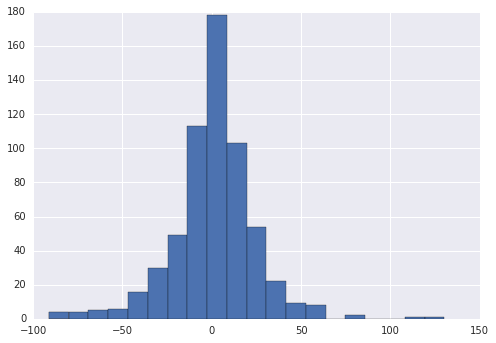

In [43]:
df_eval['error'] = df_eval['predicted'] - df_eval['target']
_ = plot.hist(df_eval['error'], bins=20)

The root mean squared error and distribution of errors indicates how the model is performing at an aggregate level as well as indicative of the span of error values.

## Prediction

Now that a model has been trained, and saved on-disk, it can be reloaded using TensorFlow, and be used to produce predictions, i.e. produce the income value given a set of new instances, or features that were not previously present in the training data. This mechanism can also help validate the model - it can be used to produce predictions for one or more evaluation datasets.

Note that prediction data must be of the same type (input format, and order of columns) as the data that was used for training. The only difference is the first column, the target income value, is absent.

Since the model is a regression model, a single value is the output of the prediction.

Also note that second column in our schema was specified as a key column. This value of the key will accompany the output values, so they can be joined with the input instances.

In [44]:
%file {workspace_path}/data/prediction.csv
SERIALNO,AGEP,COW,ESP,ESR,FOD1P,HINS4,INDP,JWMNP,JWTR,MAR,POWPUMA,PUMA,RAC1P,SCHL,SCIENGRLP,SEX,WKW
490,64,2,0,1,0,2,8090,015,01,1,00590,00500,1,18,0,2,1
1225,32,5,0,4,5301,2,9680,015,01,1,00100,00100,1,21,2,1,1
1226,30,1,0,1,0,2,8680,020,01,1,00100,00100,1,16,0,2,1

Writing /content/datalab/workspace/census/data/prediction.csv


In [45]:
df_instances = pd.read_csv(os.path.join(workspace_path, 'data/prediction.csv'))
df_instances

,SERIALNO,AGEP,COW,ESP,ESR,FOD1P,HINS4,INDP,JWMNP,JWTR,MAR,POWPUMA,PUMA,RAC1P,SCHL,SCIENGRLP,SEX,WKW
0,490,64,2,0,1,0,2,8090,15,1,1,590,500,1,18,0,2,1
1,1225,32,5,0,4,5301,2,9680,15,1,1,100,100,1,21,2,1,1
2,1226,30,1,0,1,0,2,8680,20,1,1,100,100,1,16,0,2,1


In [46]:
df_predictions = regression.predict(training_dir=training_path, data=df_instances)
df_predictions

INFO:tensorflow:Restoring parameters from /content/datalab/workspace/census/training/model/variables/variables


INFO:tensorflow:Restoring parameters from /content/datalab/workspace/census/training/model/variables/variables


INFO:tensorflow:Restoring parameters from /content/datalab/workspace/census/training/model/variables/variables


INFO:tensorflow:Restoring parameters from /content/datalab/workspace/census/training/model/variables/variables


,SERIALNO,predicted
0,490,20.665167
1,1225,52.855152
2,1226,16.163315


In [47]:
# Index the instances DataFrame using the SERIALNO column, and join the predictions
# DataFrame using the same column.
df_instances.set_index(keys=['SERIALNO'], inplace=True)
df_predictions.set_index(keys=['SERIALNO'], inplace=True)

df_data = df_predictions.join(other=df_instances)
df_data

,predicted,AGEP,COW,ESP,ESR,FOD1P,HINS4,INDP,JWMNP,JWTR,MAR,POWPUMA,PUMA,RAC1P,SCHL,SCIENGRLP,SEX,WKW
SERIALNO,,,,,,,,,,,,,,,,,,
490,20.665167,64,2,0,1,0,2,8090,15,1,1,590,500,1,18,0,2,1
1225,52.855152,32,5,0,4,5301,2,9680,15,1,1,100,100,1,21,2,1,1
1226,16.163315,30,1,0,1,0,2,8680,20,1,1,100,100,1,16,0,2,1


# Next Steps

This notebook covered key stages of the workflow locally - data preparation, data analysis, training, and prediction. Once there is a working model, the next step is to use the full dataset, and scale to much larger data volumes by performing these steps in cloud using BigQuery, Machine Learning Engine, and Dataflow. 

Next: **[Service Preprocess](./2%2BService%2BPreprocess.ipynb)**